In [1]:
import random, os, time
from pathlib import Path
import numpy  as np
import csv
from tqdm import tqdm

# do this before importing tensorflow to get rid of annoying warning messages
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import ResNet50V2
import matplotlib.pyplot as plt

from utils import *

#### Experiment 1: Resnet feature extractor with all conv blocks frozen and extra dense layers added on top. (fewer trainable parameters)

In [2]:
input_shape = (245, 200)
feature_dims = 256 # embedding dimensions 

base_cnn = ResNet50V2(weights="imagenet", input_shape=input_shape + (3,), include_top=False) # we do not include the ResNet50 output layer

# freeze the base model
base_cnn.trainable = False

# add some dense layers on top of resnet 
output = layers.GlobalAveragePooling2D(name="avg_pool")(base_cnn.output)
output = layers.BatchNormalization()(output)
output = layers.Dense(512, activation='relu')(output)
output = layers.BatchNormalization()(output)
output = layers.Dense(384, activation='relu')(output)
output = layers.BatchNormalization()(output)
output = layers.Dense(feature_dims, activation='relu')(output)

# combine into a new feature extractor model
feature_extractor = Model(base_cnn.input, output, name="feature_extractor")

feature_extractor.summary()

Model: "feature_extractor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 245, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 251, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 123, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                  

#### Create Siamese network for triplet learning

In [3]:
"""
    Custom layer for computing the distance between extracted features of anchor image and positive/negative images
"""
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        # compute l2-distance between anchor and positive image
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        # compute average l2-distance between anchor and negative images
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


"""
    Custom training class for the siamese network, with built-in data augmentation 
"""
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=1.0, data_augment=False):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.data_augment = data_augment
        self.loss_train = metrics.Mean(name="loss")
        self.accuracy_train = metrics.Mean(name="accuracy")
        self.loss_val = metrics.Mean(name="loss")
        self.accuracy_val = metrics.Mean(name="accuracy")
  
        # data augmentation model
        self.data_augmentation = Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomZoom(height_factor=0.1, width_factor=0.1, fill_mode='constant', fill_value=0.0),
            layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant', fill_value=0.0),
            layers.RandomRotation(factor=0.02, fill_mode='constant', fill_value=0.0),
            layers.RandomContrast(factor=0.1),
            layers.RandomBrightness(factor=0.1)
        ],
        name="image_augmentor")


    def call(self, inputs):    
        return self.siamese_network(inputs)
    

    # custom training step
    @tf.function    
    def train_step(self, data):

        if self.data_augment:
            anchor, positive, negative = data
            # apply augmentations to positive and negative image batches
            anchor_aug = self.data_augmentation(anchor)
            positive_aug = self.data_augmentation(positive)
            negative_aug = self.data_augmentation(negative)
            data = (anchor_aug, positive_aug, negative_aug)

        # forward propagation on gradient tape
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # compute the loss gradients 
        grads = tape.gradient(loss, self.siamese_network.trainable_weights)

        # backproagation
        self.optimizer.apply_gradients(zip(grads,self.siamese_network.trainable_weights))

        # update the loss and accuracy metrics
        self.loss_train.update_state(loss)
        accuracy = self._compute_accuracy(data)
        self.accuracy_train.update_state(accuracy)

        return {"loss": self.loss_train.result(), "accuracy": self.accuracy_train.result()}
     

    # custom testing step
    @tf.function
    def test_step(self, data):
        # update the loss metric.
        loss = self._compute_loss(data)
        self.loss_val.update_state(loss)
        # update accuracy metric
        accuracy = self._compute_accuracy(data)
        self.accuracy_val.update_state(accuracy)
        

        return {"loss": self.loss_val.result(), "accuracy": self.accuracy_val.result()}


    # define the triplet loss function
    def _compute_loss(self, data):
        # compute distance of anchor from positive and negative images
        ap_distance, an_distance = self.siamese_network(data)
        # compute the triplet loss (we want to minimize ap_distance and maximise an_distance,
        # which is why there's a minus sign infront of an_distance, we also allow for a small margin) 
        loss = ap_distance - an_distance + self.margin   
        # make sure the loss value is non-negative
        loss = tf.maximum(loss, 0.0)
        
        return loss
    

    def _compute_accuracy(self, data):
        # compute distance of anchor from positive and negative images
        ap_distance, an_distance = self.siamese_network(data)
        accuracy = tf.reduce_mean(tf.cast(ap_distance < an_distance, tf.float32))

        return accuracy


    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]
    

"""
    Custom training loop for the siamese network
"""
def train(model, train_dataset, val_dataset, num_epoches=5, checkpoint=None, checkpoint_file_prefix=None, checkpoint_freq=2):
    num_batches_train = tf.data.experimental.cardinality(train_dataset).numpy()
    num_batches_val = tf.data.experimental.cardinality(val_dataset).numpy()
    for epoch in range(num_epoches):
        start_time = time.time()
        print(f"Epoch {epoch+1}/{num_epoches}")
        
        # training 
        with tqdm(total=num_batches_train, desc='Training') as pbar:
            for data_batch in train_dataset:
                metrics = model.train_step(data_batch)
                pbar.update()
                pbar.set_postfix({'Loss' : metrics['loss'].numpy(), 'Accuracy' : metrics['accuracy'].numpy()})

        # save checpoint every two epochs
        if checkpoint and ((epoch+1)%checkpoint_freq == 0):
            # save model checkpoint
            checkpoint.save(checkpoint_file_prefix) 
            print(f"Saved checkpoint for epoch {epoch+1} at {checkpoint_file_prefix}")

        # validation
        with tqdm(total=num_batches_val, desc='Validation') as pbar:
            for data_batch in val_dataset:
                metrics = model.test_step(data_batch)
                pbar.update()
                pbar.set_postfix({'Loss' : metrics['loss'].numpy(), 'Accuracy' : metrics['accuracy'].numpy()})

        print(f"Total time for epoch: {time.time()-start_time:.2f} sec")

In [4]:
# instantiate model object and compile it   
anchor_input = layers.Input(shape=input_shape + (3,), name="anchor")    
positive_input = layers.Input(shape=input_shape + (3,), name="positive")    
negative_input = layers.Input(shape=input_shape + (3,), name="negative")    

distances = DistanceLayer()(feature_extractor(anchor_input), feature_extractor(positive_input), feature_extractor(negative_input))

# define the siamese network model
siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs = distances)

siamese_model = SiameseModel(siamese_network, margin=1.0, data_augment=False)
opt = optimizers.Adam(learning_rate=0.001)  
siamese_model.compile(optimizer=opt)    

#### Load training and validation triplet datasets

In [5]:
triplets_train, triplets_val, anchor_paths_train, positive_paths_train, anchor_paths_val, positive_paths_val = train_val_split(num_negatives=20)

(245, 200, 3)


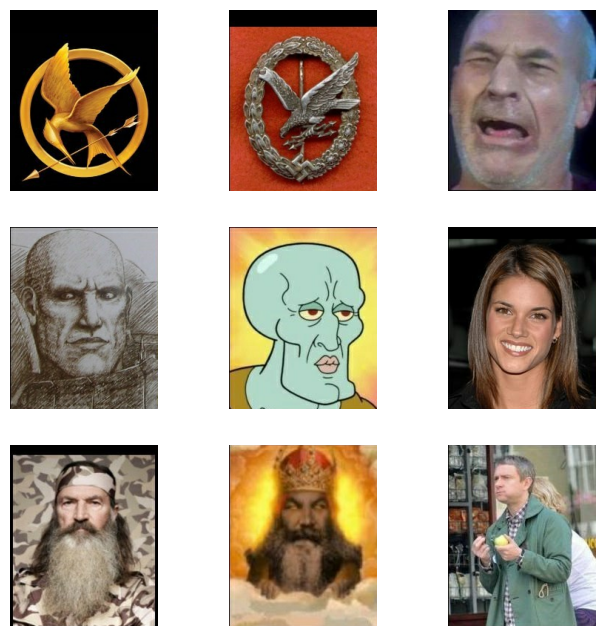

In [6]:
# visualize some examples from training set
visualize(triplets_train)

#### Train the model

In [7]:
# setup training checkpoint manager
checkpoint_dir = './models/experiment_1_checkpoints'
checkpoint_file_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=opt, model=siamese_model)

In [8]:
train(siamese_model, triplets_train, triplets_val, num_epoches=10, checkpoint=checkpoint, checkpoint_file_prefix=checkpoint_file_prefix, checkpoint_freq=5)

Epoch 1/10


Validation: 100%|██████████| 250/250 [01:14<00:00,  3.37it/s, Loss=0.861, Accuracy=0.765]


Total time for epoch: 373.87 sec
Epoch 2/10


Validation: 100%|██████████| 250/250 [01:12<00:00,  3.47it/s, Loss=1.04, Accuracy=0.757] 


Total time for epoch: 362.57 sec
Epoch 3/10


Validation: 100%|██████████| 250/250 [01:12<00:00,  3.47it/s, Loss=1.05, Accuracy=0.764]


Total time for epoch: 362.18 sec
Epoch 4/10


Validation: 100%|██████████| 250/250 [01:21<00:00,  3.05it/s, Loss=1.11, Accuracy=0.765]


Total time for epoch: 371.89 sec
Epoch 5/10


Training: 100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s, Loss=0.125, Accuracy=0.982]


Saved checkpoint for epoch 5 at ./models/experiment_1_checkpoints/ckpt


Validation: 100%|██████████| 250/250 [01:12<00:00,  3.47it/s, Loss=1.14, Accuracy=0.766]


Total time for epoch: 364.33 sec
Epoch 6/10


Validation: 100%|██████████| 250/250 [01:12<00:00,  3.47it/s, Loss=1.17, Accuracy=0.766]


Total time for epoch: 362.32 sec
Epoch 7/10


Training:  66%|██████▌   | 658/1000 [03:11<01:40,  3.41it/s, Loss=0.106, Accuracy=0.986]

#### Model evaluation strategy

To evaluate our model, we create sets of 20 candidate images from the validation set images for each left image, with the corresponding right image being among the candidates. Then we predicty the squared euclidean distance between the left image and each candidate image and assign similarity scores. Then we caclculate the top-1, top-2 and top-5 accuracies based on whether the ground truth right image is among the images with highest similarity scores. 

In [ ]:
def validation_accuracy(anchor_paths, positive_paths, debug=False):

    # combine the anchor and positive image sets and shuffle it up
    all_paths = anchor_paths + positive_paths
    np.random.RandomState(seed=32).shuffle(all_paths)
    
    top_1_predictions = np.zeros(shape=(len(anchor_paths)))
    top_2_predictions = np.zeros(shape=(len(anchor_paths)))
    top_5_predictions = np.zeros(shape=(len(anchor_paths)))
    similarity_scores = np.zeros(shape=(len(anchor_paths),20))
    candidates_paths = []
    
    # iterate over each left image in validation set
    for i in range(len(anchor_paths)):
        # randomly sample 21 other candidates without replacement
        candidates = random.sample(all_paths, 21) 
        # check if we sampled the left or right image, if so remove
        candidates = [img for img in candidates if img != anchor_paths[i] and img != positive_paths[i]][:20]
        # add the right image to the list of candidates
        candidates = [positive_paths[i]] + candidates
        candidates_paths.append(candidates)

        # preprocess the images, convert to tensors and compute embedding vectors
        left_embedding = feature_extractor(tf.expand_dims(preprocess_image(anchor_paths[i]),0))
        candidate_images = []
        for path in candidates:
            candidate_images.append(preprocess_image(path))
        candidates = tf.convert_to_tensor(candidate_images)            # convert bacth of candidates to tensor   
        candidate_embeddings = feature_extractor(candidates)           # compute embeddings
        
        # now compute euclidean distances between the left image embedding and candidate image embeddings 
        diff = tf.square(candidate_embeddings - left_embedding)
        euclidean_dist = tf.reduce_sum(diff, axis=1).numpy()
        # apply min-max normalization to the distances
        euclidean_dist = (euclidean_dist - np.min(euclidean_dist)) / (np.max(euclidean_dist) - np.min(euclidean_dist))
        
        # convert normalized distances to similarity score
        scores = 1-euclidean_dist
        similarity_scores[i,:] = scores

        # compute top 1, 2 and 5 accuracy
        top_1_indices = scores.argsort()[-1:][::-1]
        top_2_indices = scores.argsort()[-2:][::-1]
        top_5_indices = scores.argsort()[-5:][::-1]

        top_1_predictions[i] = int(0 in top_1_indices)
        top_2_predictions[i] = int(0 in top_2_indices)
        top_5_predictions[i] = int(0 in top_5_indices)

        if debug: 
            print(f"Validation image # {i}, Candidate similarity scores: {similarity_scores}, top1_pred = {top_1_predictions[i]}, top2_pred = {top_2_predictions[i]}, top5_pred = {top_5_predictions[i]}, ")

    # compute accuracy
    top_1_accuracy = np.sum(top_1_predictions)/len(top_1_predictions) 
    top_2_accuracy = np.sum(top_2_predictions)/len(top_2_predictions) 
    top_5_accuracy = np.sum(top_5_predictions)/len(top_5_predictions) 
    print(f"Top 1 accuracy = {top_1_accuracy}, Top 2 accuracy = {top_2_accuracy}, Top 5 accuracy = {top_5_accuracy}")

    return similarity_scores, candidates_paths


In [ ]:
def visualize_predictions(anchor_paths, candidate_paths, scores):
    
    # convert to numpy arrays
    left = preprocess_image(anchor_paths).numpy()
    candidates = []
    for candidate_path in candidate_paths:
        candidates.append(preprocess_image(candidate_path).numpy())  
    
    # plot left image
    fig = plt.figure(figsize=(2, 2))
    plt.imshow(left)
    plt.axis('off')
    plt.title("left image")

    # plot candidates     
    fig = plt.figure(figsize=(20, 6))  
    for i in range(20):
        plt.subplot(2,10,i+1)
        plt.imshow(candidates[i])
        plt.axis('off')
        plt.title('C' + str(i) + ', score:' + str(round(scores[i],3)), fontsize=8)

    plt.show()